## Sprite Text2Img Attention Experiments
Tries to apply attention to the text to image sprites

Based on the tutorial found here: https://www.tensorflow.org/tutorials/text/image_captioning

---


### Imports and Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# tensorflow
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Conv2DTranspose, Flatten, Layer, Reshape, Input, LeakyReLU, MaxPooling2D, Concatenate, Conv1D, Lambda, BatchNormalization, UpSampling2D, Add, GRU, Embedding
from tensorflow.keras.models import Model


%matplotlib inline

/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-02 19:46:26.653970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import from Python folder to get the utils
import sys
sys.path.append('../Python')
from utils import picoSS2np, showMultiSprPalette, showMultiSprRGB, showSprRGB, showSprPalette, animatePal, encodeSpr1H, decodeSpr1H, showTxtEmb

In [3]:
### CONSTANT VARIABLES   ###

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


Food Dataset shape: (100, 8, 8)
Char Dataset shape: (100, 8, 8)


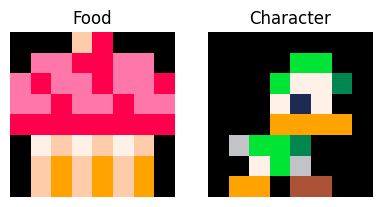

In [4]:
# import from the PICO sprites posted onto Twitter 
# Food: https://twitter.com/JUSTIN_CYR/status/634546317713391616
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_food_dat = np.load('../data/rip_data/pico_food.npy',allow_pickle=True)
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)

print(f"Food Dataset shape: {pico_food_dat.shape}")
print(f"Char Dataset shape: {pico_char_dat.shape}")

# show a random food and character sprite 
rand_food = random.choice(pico_food_dat)
rand_char = random.choice(pico_char_dat)
showMultiSprPalette([rand_food,rand_char],textArr=['Food','Character'])

In [5]:
# import sentence-transformer for text embedding 
SBERT_MODEL = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

def sentEmb(txt):
    return SBERT_MODEL.encode([txt])[0]

# import the text data
pico_char_labels = np.array([l.strip() for l in open('../data/rip_data/character_desc.txt','r').readlines()])

# encode the labels
pico_char_emb = []
with tqdm(total=len(pico_char_labels)) as pbar:
    pbar.set_description("Encoding labels")
    for l in pico_char_labels:
        pico_char_emb.append(sentEmb(l))
        pbar.update(1)

pico_char_emb = np.array(pico_char_emb)

Encoding labels: 100%|██████████| 100/100 [00:01<00:00, 77.03it/s]


In [6]:
# import keras embedder bert for 2d encoding with the attention layer

from keras_nlp.models import BertBackbone, BertTokenizer, BertPreprocessor
backbone = BertBackbone.from_preset('bert_tiny_en_uncased')
tokenizer = BertTokenizer.from_preset('bert_tiny_en_uncased')
preprocessor = BertPreprocessor.from_preset('bert_tiny_en_uncased')

pico_char_emb2d = []
with tqdm(total=len(pico_char_labels)) as pbar:
    pbar.set_description("Encoding labels (2d)")
    for l in pico_char_labels:
        pico_char_emb2d.append(backbone(preprocessor([l]))['sequence_output'].numpy()[0])
        pbar.update(1)

pico_char_emb2d = np.array(pico_char_emb2d)
print(pico_char_emb2d.shape)

2023-05-02 19:46:34.068811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Encoding labels (2d): 100%|██████████| 100/100 [00:15<00:00,  6.48it/s]

(100, 512, 128)


Character: a red robot dog


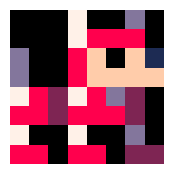

Encoding length: 384


In [7]:
# show a random character and its description
rand_char_idx = random.randint(0,len(pico_char_labels))
print(f"Character: {pico_char_labels[rand_char_idx]}")
showSprPalette(pico_char_dat[rand_char_idx])

desc_enc = pico_char_emb[rand_char_idx]
print(f"Encoding length: {len(desc_enc)}")

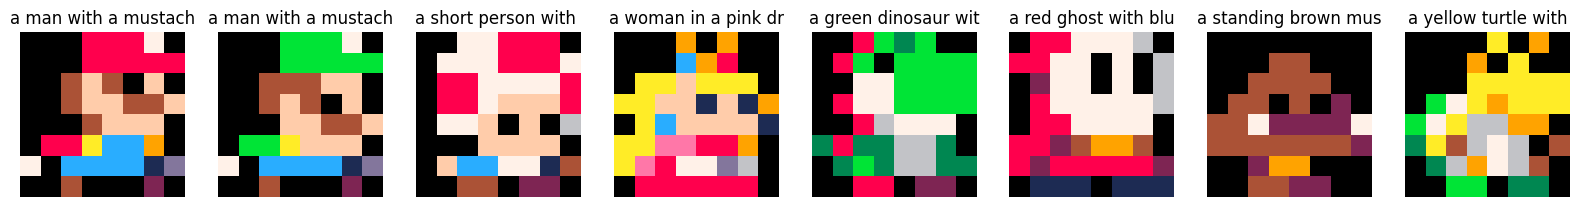

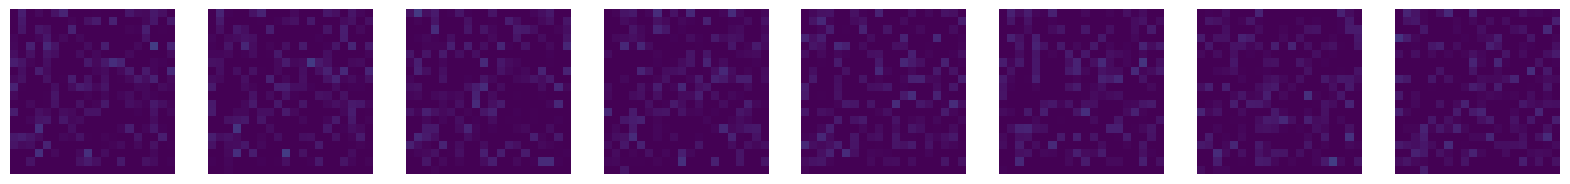

In [8]:
# show the text embedding	
showMultiSprPalette(pico_char_dat[:8],textArr=[l[:20] for l in pico_char_labels[:8]])
showTxtEmb(pico_char_emb[:8])

In [89]:
# get test sets to test the model

mod_test_set = {
    'real': {'text':['Mario','Koopa','Leonardo','Finn','Dewey','Link','Samus','Pikachu'], 'emb':pico_char_emb2d[GEN_CONF['REAL_TEST_INDEX']]},
    'fake': {'text':["a blue turtle standing up", "a woman with green hair", "a duck with a yellow shirt", "a man with a red hat", "a man with a purple bandana", "a dog with sunglasses", "a girl with an orange outfit", "a yellow monkey with green cheeks"]}
}
mod_test_set['fake']['emb'] = []
with tqdm(total=len(mod_test_set['fake']['text'])) as pbar:
    pbar.set_description("Encoding labels (2d) - test set")
    for l in mod_test_set['fake']['text']:
        mod_test_set['fake']['emb'].append(backbone(preprocessor([l]))['sequence_output'].numpy()[0])
        pbar.update(1)

Encoding labels (2d) - test set: 100%|██████████| 8/8 [00:01<00:00,  6.87it/s]


In [9]:
###   CONFIUGURATIONS   ###

EXPERIMENT = "tf_tutorial"

GEN_CONF = {
    "EPOCHS" : 20,
    "BATCH_SIZE" : 16,
    "LEARNING_RATE" : 0.001,
    "WINDOW" : 8,
    "REAL_TEST_INDEX": [0,7,30,53,86,90,96,99]
}

### General Setup

In [10]:
# create the training dataset (embheddings -> images)
pico_char_emb = SBERT_MODEL.encode(pico_char_labels)
pico_char_emb = np.array(pico_char_emb)

X_train = pico_char_emb2d
Y_train = np.array([encodeSpr1H(s) for s in pico_char_dat])

print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")

X_train: (100, 512, 128)
Y_train: (100, 8, 8, 16)


In [11]:
'''
  # Define the attention layer (Bahdanau et al. 2014)
    from various sources: 
    - https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa
    - https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation/
    - https://blog.paperspace.com/seq-to-seq-attention-mechanism-keras/
'''
class Attention_B(Model):
    def __init__(self, units):
        super(Attention_B, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        # features shape == (batch_size, max_length, embedding_dim) ; features from the encoder
        # hidden shape == (batch_size, hidden size) ; hidden state from the Encoder?
        # hidden_with_time_axis shape == (batch_size, 1, hidden size) ; add time axis to hidden
        # score shape == (batch_size, max_length, 1) ; gives unnormalized score for each image feature

        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, max_length, 1) ; softmax normalized scores
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size) ; weighted sum of image features
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [12]:
# test the attention layer
# fuck it - none of these numbers make sense
UNITS = 10
att_test = Attention_B(UNITS)
feat = random.choice(pico_char_emb2d)   # get the text features from the bert model => (1,512,128) - (batch, emb_dim)
feat = tf.expand_dims(feat,0)         # add batch dimension
hidden = tf.zeros((1,UNITS))          # initial hidden state (zeros) - (batch, units)

context_vector, attention_weights = att_test(feat, hidden)
print(f"[INPUT SHAPES] feat (batch, emb_dim): {feat.shape} ; hidden (batch, units): {hidden.shape}")
print(f"[OUTPUT SHAPES] ctx_vec (batch, hidden_size): {context_vector.shape} ; att_weights (batch, attn_feat_shape, 1): {attention_weights.shape}")
print(f"[VALUES] ctx_vec: {context_vector} ; att_weights: {attention_weights}")


[INPUT SHAPES] feat (batch, emb_dim): (1, 512, 128) ; hidden (batch, units): (1, 10)
[OUTPUT SHAPES] ctx_vec (batch, hidden_size): (1, 128) ; att_weights (batch, attn_feat_shape, 1): (1, 512, 1)
[VALUES] ctx_vec: [[-5.42847738e-02  1.11601189e-01  6.76184416e-01 -3.41657543e+00
   1.14473268e-01  1.16734199e-01 -7.49289870e-01 -1.83225811e-01
  -1.14289951e+00 -4.47282158e-02  4.74803239e-01  8.66881132e-01
   2.44205952e-01 -2.91326605e-02  6.75856054e-01 -8.37973118e-01
   1.82310562e-03  3.55423927e-01 -2.64850646e-01  1.75994420e+00
  -8.54502842e-02  5.12096822e-01 -9.23232436e-01  5.71554542e-01
   3.04787815e-01 -8.61314416e-01  3.83434623e-01  4.63069618e-01
  -2.73754299e-01 -7.48768449e-01 -1.05779994e+00 -1.57603490e+00
  -2.34792709e+00 -5.69795370e-01  6.40948057e-01 -1.23618984e+00
  -2.62274563e-01 -9.19812739e-01 -1.64819241e+00 -8.70173752e-01
  -2.93170195e-03 -4.67404164e-03  1.52905607e+00 -1.67785871e+00
   1.47163606e+00 -2.18227792e+00 -8.77013683e-01 -8.18893731

In [13]:
# define the decoder model
# from https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa
class AttBDec(Model):
    def __init__(self, txt_emb_dim, units, vocab_dim):
        super(AttBDec, self).__init__()
        self.units = units
        self.embedding = Embedding(vocab_dim, txt_emb_dim)
        # self.embedding = Dense(vocab_dim)
        self.attention = Attention_B(self.units)
        self.gru = GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = Dense(self.units)
        self.fc2 = Dense(vocab_dim)

    def call(self, x, features, hidden):
        ctx_vec, attn_weights = self.attention(features, hidden)
        x = self.embedding(x)  # batch, 1, txt_emb_dim
        x = tf.concat([tf.expand_dims(ctx_vec, 1), x], axis=-1)    #batch, 1, txt_emb_dim + hidden_size
        output, state = self.gru(x)
        x = self.fc1(output)   #batch, max_len, hidden_size
        x = tf.reshape(x, (-1, x.shape[2]))   #batch * max_len, hidden_size
        x = self.fc2(x)       #batch * max_len, vocab_dim
        return x, state, attn_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [14]:
# encoder for the text embeddings ; used for positional encoding from the frozen model
# might need to be changed (this was intended for image-to-caption system)
# taken from https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa
# and https://towardsdatascience.com/implementing-neural-machine-translation-with-attention-using-tensorflow-fc9c6f26155f
class AttBEnc(Model):
    def __init__(self, emb_dim):
        super(AttBEnc, self).__init__()
        self.fc = Dense(emb_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [59]:
# test the encoder+decoder idk - SANITY CHECKS
whatev_dim = 128   # this value can be whatever as long as it is also passed to the decoder
units = 10
out_emb_dim = 16
BATCH = 3

test_dat = pico_char_emb2d[:BATCH]
flat_spr = np.reshape(pico_char_dat[:BATCH],(BATCH,-1))   # flatten the sprite
print(f"spr (og y): {pico_char_dat[:BATCH].shape}")
print(f"flat spr (y): {flat_spr.shape}")

# encoder [GOOD]
test_enc = AttBEnc(whatev_dim)  # encodes the text embeddings
enc_feat = test_enc(test_dat)   #this becomes 'features'
print(f"feat: {enc_feat.shape}")

# decoder (pass it the current sprite as x and then build the next sprite from the output)
test_dec = AttBDec(whatev_dim, units, out_emb_dim)
hidden = test_dec.reset_state(BATCH)
print(f"hidden: {hidden.shape}")
start_spr = tf.expand_dims(flat_spr[:,1],1)    # get the first pixel of each sprite in the batch
print(f"x: {start_spr.shape} - {type(start_spr)}")
pred, hidden, attn_weights = test_dec(start_spr, enc_feat, hidden)
print(f"pred: {pred.shape}")

print("")
start_spr2 = tf.expand_dims(flat_spr[:,2],1)
print(f"x2: {start_spr2.shape} - {type(start_spr2)}")
pred, hidden, attn_weights = test_dec(start_spr2, enc_feat, hidden)
print(f"pred2: {pred.shape}")


spr (og y): (3, 8, 8)
flat spr (y): (3, 64)
feat: (3, 512, 128)
hidden: (3, 10)
x: (3, 1) - <class 'tensorflow.python.framework.ops.EagerTensor'>
pred: (3, 16)

x2: (3, 1) - <class 'tensorflow.python.framework.ops.EagerTensor'>
pred2: (3, 16)


In [60]:
# test the loss function
lo = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_func(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))   # get the mask of the true values
    loss_ = lo(y_true, y_pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask   # apply the mask

    return tf.reduce_mean(loss_)

real = flat_spr[:,3]
print(f"real: {real.shape}")
print(real)
print(f"pred: {pred.shape}")
loss = loss_func(real, pred)
print(f"loss: {loss}")


real: (3,)
[ 8 11  7]
pred: (3, 16)
loss: 2.8590002059936523


#### Train?

In [123]:
# Give it the old college try
class FuckIt(Model):
    def __init__(self, whatev_dim, units, out_emb_dim, batch_size=16):
        super().__init__()

        self.batch_size = batch_size

        # define the encoder
        self.ENC = AttBEnc(whatev_dim)
        self.DEC = AttBDec(whatev_dim, units, out_emb_dim)

        # define loss and optimizer
        self.opt = tf.keras.optimizers.Adam()
        self.loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        

    def loss_func(self,y_true, y_pred):
        mask = tf.math.logical_not(tf.math.equal(y_true, 0))   # get the mask of the true values
        loss_ = self.loss_obj(y_true, y_pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask   # apply the mask

        return tf.reduce_mean(loss_)

    def train_step(self,data):
        text_enc, flat_img_targ = data
        loss = 0

        hidden = self.DEC.reset_state(self.batch_size)
        dec_input = tf.expand_dims(flat_img_targ[:,0],1)
    

        with tf.GradientTape() as tape:
            enc_feat = self.ENC(text_enc)

            with tqdm(total=flat_img_targ.shape[1]-1) as pbar:
                for i in range(1, flat_img_targ.shape[1]):
                    # print(f"dec_input: {dec_input.shape}")
                    # print(f"enc_feat: {enc_feat.shape}")
                    # print(f"hidden: {hidden.shape}")

                    pred, hidden, _ = self.DEC(dec_input, enc_feat, hidden)
                    loss += self.loss_func(flat_img_targ[:,i], pred)
                    dec_input = tf.expand_dims(flat_img_targ[:,i],1)
                    # dec_input = tf.expand_dims(flat_img_targ[:, i - 1:i], 1)

                    # print(f"hidden: {hidden.shape}")
                    pbar.update(1)


        total_loss = (loss / int(flat_img_targ.shape[1]))
        variables = self.ENC.trainable_variables + self.DEC.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.opt.apply_gradients(zip(gradients, variables))

        return {"loss":total_loss}


In [124]:
X_train = pico_char_emb2d
y_train = np.reshape(pico_char_dat,(pico_char_dat.shape[0],-1))

In [126]:
whatev_dim = 1024      # this value can be whatever as long as it is also passed to the decoder
units = 100           # dense layer units in the attention model
pix_channels = 16   # final output embedding dimension (channels)
BATCH_SIZE = 10

idfk = FuckIt(whatev_dim, units, pix_channels,BATCH_SIZE)
idfk.compile(idfk.opt)


In [127]:
idfk.fit(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True, epochs=20, verbose=True)

Epoch 1/20


100%|██████████| 63/63 [00:13<00:00,  4.81it/s]


10/10 [==============================] - 122s 4s/step - loss: 1.7033
Epoch 2/20
10/10 [==============================] - 28s 3s/step - loss: 1.5308
Epoch 3/20
10/10 [==============================] - 26s 3s/step - loss: 1.3436
Epoch 4/20
10/10 [==============================] - 26s 3s/step - loss: 1.2370
Epoch 5/20
10/10 [==============================] - 26s 3s/step - loss: 1.1769
Epoch 6/20
10/10 [==============================] - 27s 3s/step - loss: 1.1328
Epoch 7/20
10/10 [==============================] - 27s 3s/step - loss: 1.1142
Epoch 8/20
10/10 [==============================] - 27s 3s/step - loss: 1.0862
Epoch 9/20
10/10 [==============================] - 27s 3s/step - loss: 1.0753
Epoch 10/20
10/10 [==============================] - 32s 3s/step - loss: 1.0472
Epoch 11/20
10/10 [==============================] - 38s 4s/step - loss: 1.0397
Epoch 12/20
10/10 [==============================] - 34s 3s/step - loss: 1.0231
Epoch 13/20
10/10 [==============================] - 31s 3s

In [132]:

idfk.ENC.summary()
idfk.DEC.summary()

Model: "att_b_enc_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           multiple                  132096    
                                                                 
Total params: 132,096
Trainable params: 132,096
Non-trainable params: 0
_________________________________________________________________
Model: "att_b_dec_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    multiple                  16384     
                                                                 
 attention_b_18 (Attention_B  multiple                 112701    
 )                                                               
                                                                 
 gru_17 (GRU)                multiple                  645000    
                          

#### Inference

In [133]:
# get a new sprite from a passed text encoding prompt
def inference(att_mod, enc_prompts):
    hidden = att_mod.DEC.reset_state(enc_prompts.shape[0])
    dec_input = tf.expand_dims([0]*enc_prompts.shape[0],1)  #black corner pixel
    enc_feat = att_mod.ENC(enc_prompts)

    # print(f"prompt: {enc_prompts.shape}")
    # print(f"hidden: {hidden.shape}")
    # print(f"dec_input: {dec_input.shape}")
    # print(f"enc_feat: {enc_feat.shape}")      

    result = []
    attention_plot = np.zeros((enc_prompts.shape[0], 64, 64))
    for i in range(64):
        pred, hidden, _ = att_mod.DEC(dec_input, enc_feat, hidden)
        # attention_plot[:, i] = tf.reshape(attn_weights, (-1, )).numpy()
        pix_val = tf.argmax(pred, axis=1)
        result.append(pix_val.numpy())  
        dec_input = tf.expand_dims(pix_val,1)

    #fix the shape
    result = np.array(result)
    result = np.transpose(result, (1,0))
    result = np.reshape(result, (result.shape[0], 8, 8))

    return result, attention_plot

# inference(idfk, pico_char_emb2d[:3])
inference(idfk, np.expand_dims(pico_char_emb2d[0],axis=0))[0]


array([[[15, 15, 15, 15, 15, 15, 15, 15],
        [15, 15, 15, 15, 15, 15, 15, 15],
        [15, 15, 15, 15, 15, 15, 15, 15],
        [15, 15, 15, 15, 15, 15, 15, 15],
        [15, 15, 15, 15, 15, 15, 15, 15],
        [15, 15, 15, 15, 15, 15, 15, 15],
        [15, 15, 15, 15, 15, 15, 15, 15],
        [15, 15, 15, 15, 15, 15, 15, 15]]])

In [134]:
real_out = []
fake_out = []

real_out = inference(idfk, mod_test_set['real']['emb'])[0]
fake_out = inference(idfk, np.array(mod_test_set['fake']['emb']))[0]

In [135]:
print(np.array(real_out).shape)
print(np.array(fake_out).shape)

(8, 8, 8)
(8, 8, 8)


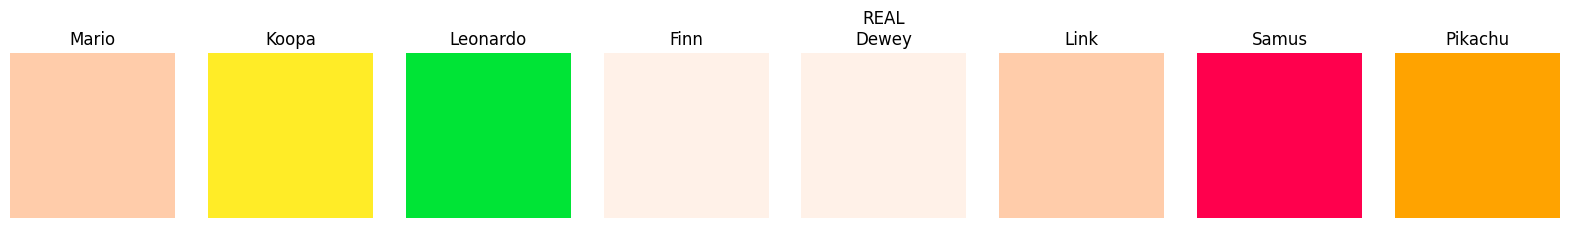

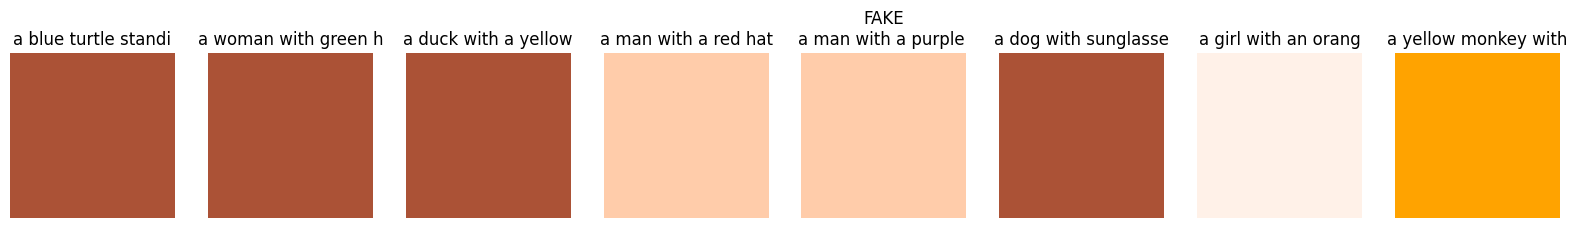

In [136]:
# give test images for the model to generate
def showOut(imgs,txts,embs=None,title='',showEmb=True):
    showMultiSprPalette(imgs,text=title,textArr=[t[:20] for t in txts])
    if showEmb and embs is not None:
        showTxtEmb(embs)

showOut(real_out,mod_test_set['real']['text'],mod_test_set['real']['emb'],title='Real',showEmb=False)
showOut(fake_out,mod_test_set['fake']['text'],mod_test_set['fake']['emb'],title='Fake',showEmb=False)